In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [45]:
train_data = pd.read_csv("BG2023_train.csv")
val_data = pd.read_csv("BG2023_validation.csv")

tr_X = train_data.iloc[:, 1:]
tr_Y = train_data.iloc[:, 0]
forecast_X = val_data

In [133]:
tr_X.shape

(10000, 79)

In [134]:
len(forecast_X)

20000

## Distribution

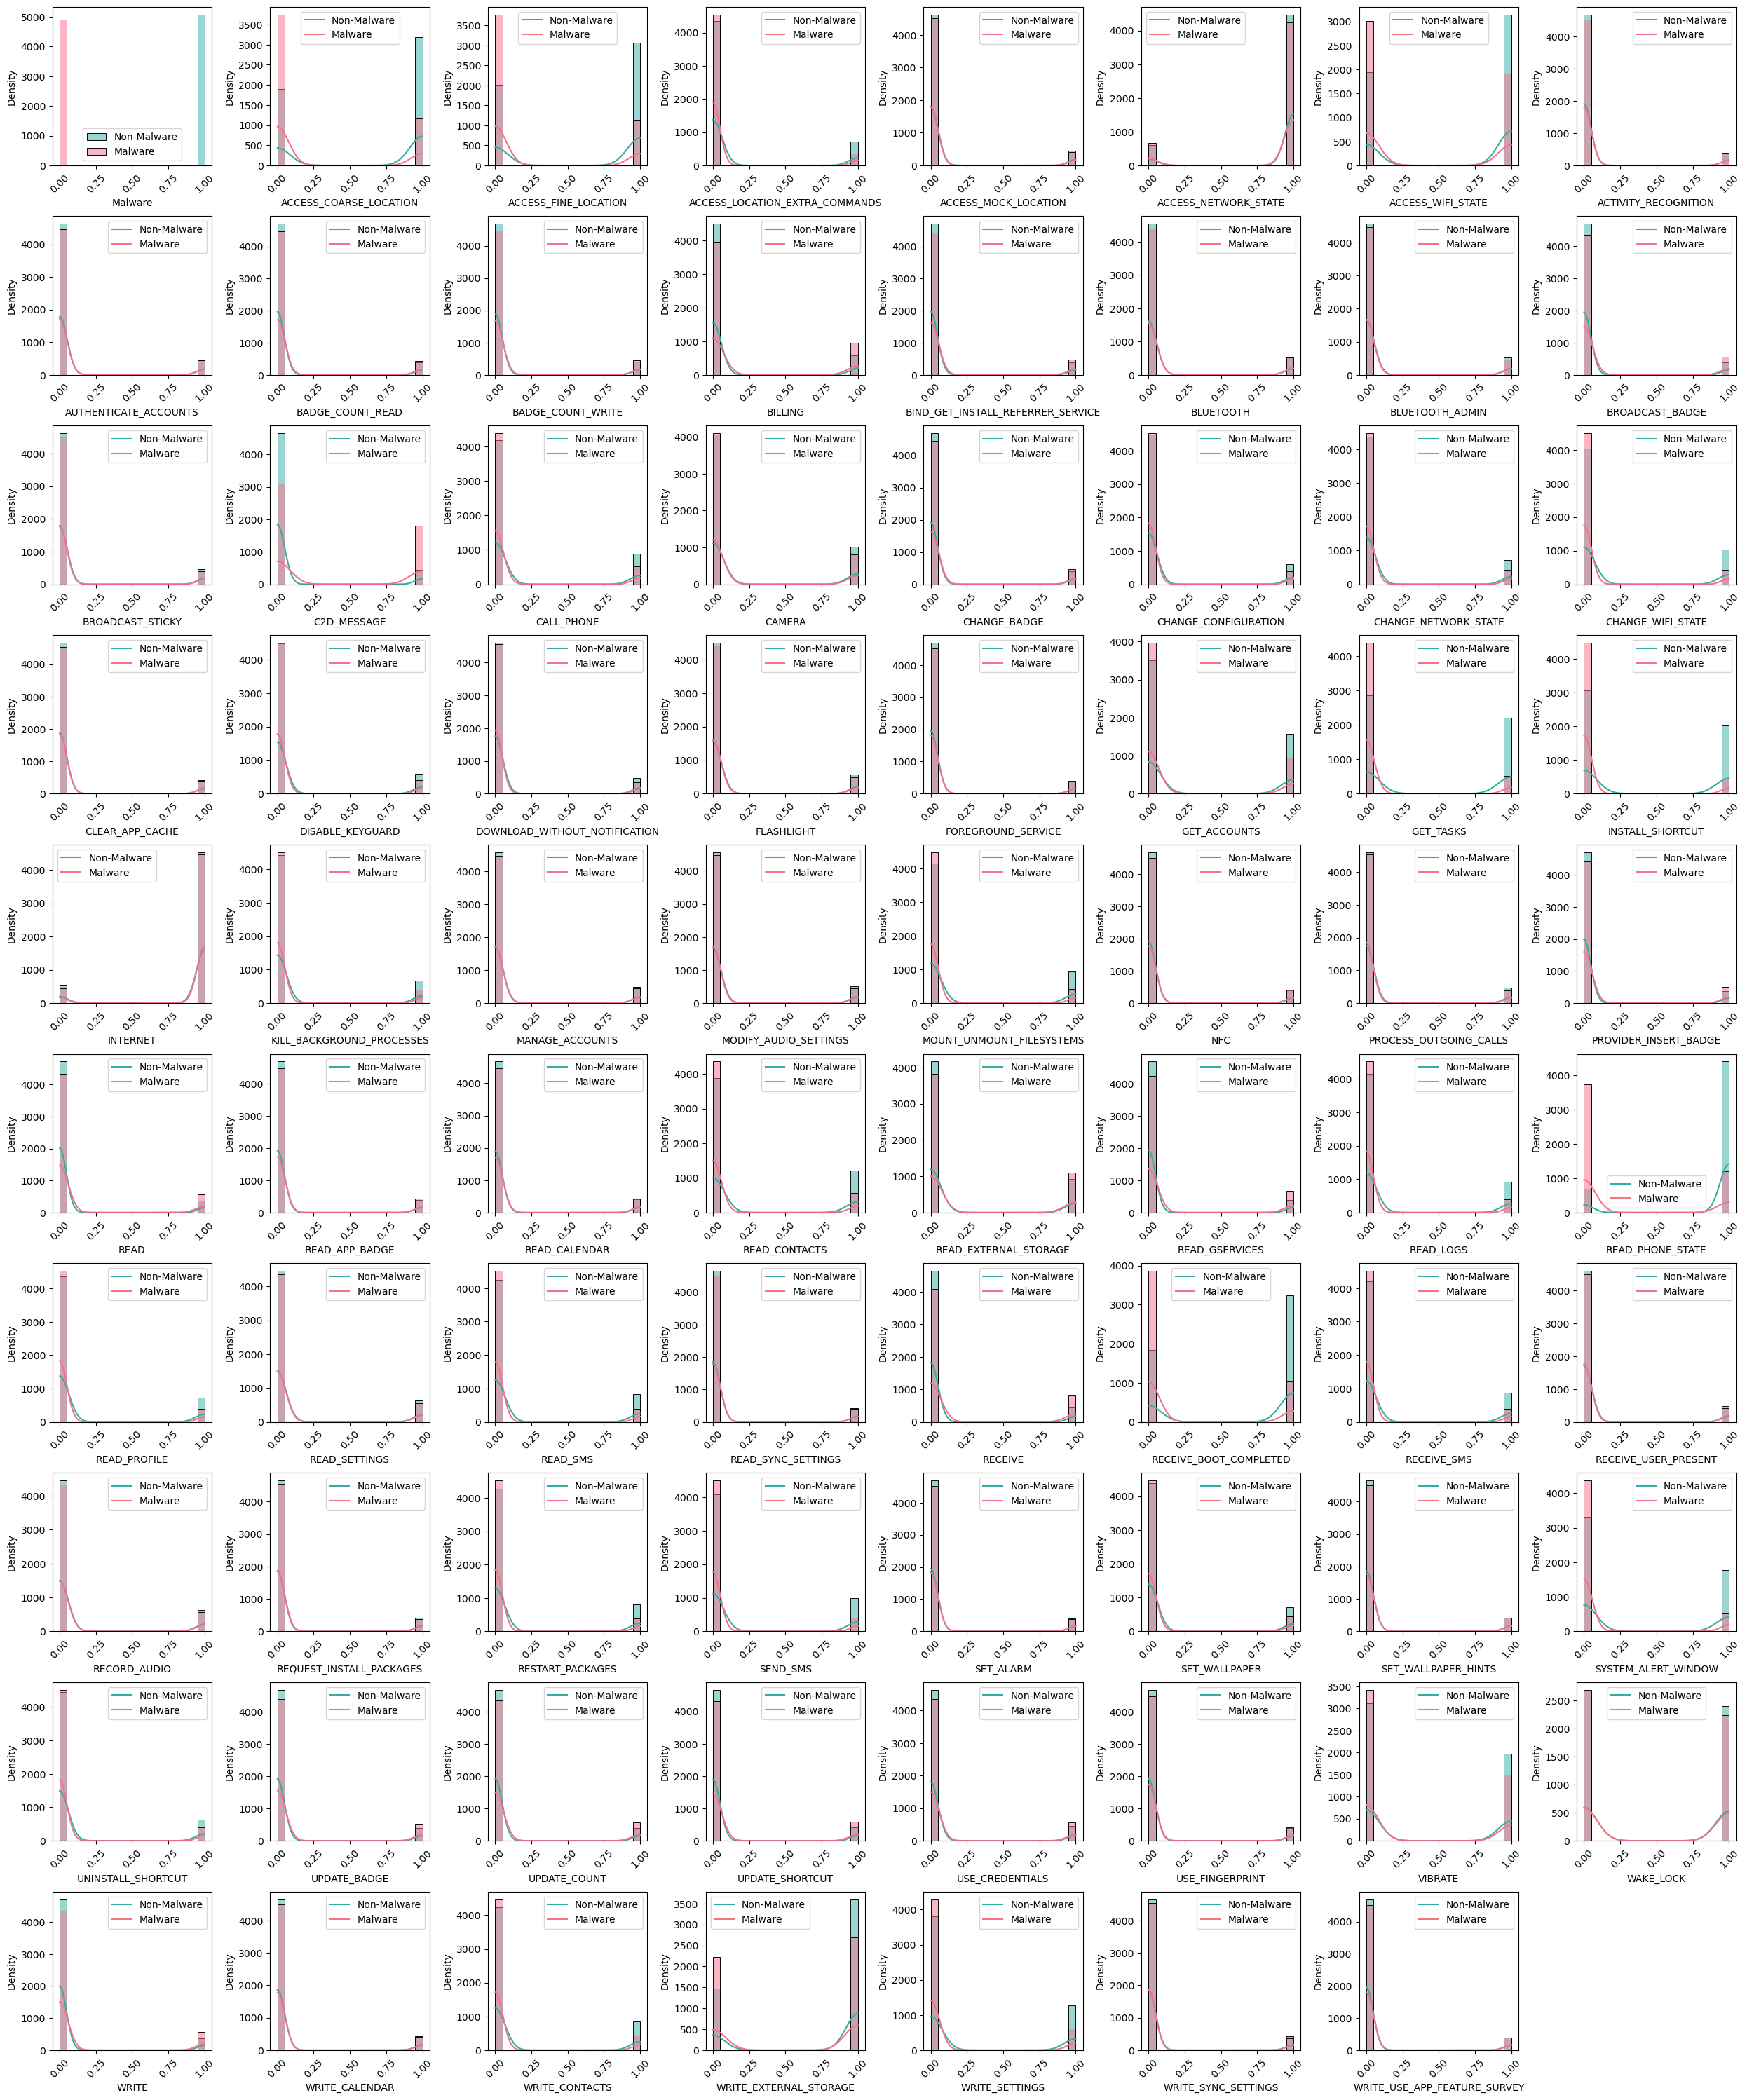

In [14]:
num_features = len(train_data.columns) - 1  # Exclude the 'Malware' column
num_rows = 10  # Number of rows in the grid
num_cols = (num_features + num_rows - 1) // num_rows  # Compute the number of columns based on the number of features

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 30))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Iterate over each feature and plot its distribution
for i, feature_name in enumerate(train_data.columns[:-1]):  # Exclude the 'Malware' column
    ax = axes[i]
    sns.histplot(train_data, x=feature_name, hue='Malware', bins=20, kde=True, palette='husl', ax=ax)
    ax.set_xlabel(feature_name, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(['Non-Malware', 'Malware'])

# Hide empty subplots
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

## Data augmentation

In [3]:
malware_samples = train_data[train_data['Malware'] == 1]
augmented_data = []

for index, sample in malware_samples.iterrows():
    # Randomly select one or more features with value 0 and change them to 1
    augmented_sample = sample.copy()  # Make a copy of the original sample
    num_features_to_change = np.random.randint(1, len(sample))  # Randomly select the number of features to change
    features_to_change = np.random.choice(sample.index[1:], size=num_features_to_change, replace=False)  # Randomly select features to change
    augmented_sample[features_to_change] = 1  # Set selected features to 1
    augmented_data.append(augmented_sample)

# Convert the list of augmented samples to a DataFrame
augmented_data_df = pd.DataFrame(augmented_data)

# Concatenate the original dataset with the augmented dataset
augmented_dataset = pd.concat([train_data, augmented_data_df], ignore_index=True)

# Shuffle the dataset to randomize the order of samples
augmented_dataset = augmented_dataset.sample(frac=1).reset_index(drop=True)


In [4]:
augmented_dataset.shape

(15085, 80)

In [5]:
augmented_tr_X = augmented_dataset.iloc[:, 1:]
augmented_tr_Y = augmented_dataset.iloc[:, 0]


In [16]:
len(forecast_X)

20000

## SMOTE

In [6]:
from collections import Counter
from imblearn.over_sampling import SMOTE
counter = Counter(augmented_tr_Y)
print ('Before', counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
vectors_sm, labels__sm = smt.fit_resample(augmented_tr_X, augmented_tr_Y)
counter = Counter(labels__sm)
print('After', counter)

Before Counter({1: 10170, 0: 4915})
After Counter({0: 10170, 1: 10170})


## Logistic regression

In [10]:
model = LogisticRegression()
model.fit(tr_X, tr_Y)

y_pred = model.predict(forecast_X)

## Random Forest

In [47]:
model = RandomForestClassifier(n_estimators=20000, random_state=42)  # You can adjust n_estimators as needed
model.fit(tr_X, tr_Y)
# model.fit(augmented_tr_X, augmented_tr_Y)

y_pred = model.predict(forecast_X)

## Gradient Boosting Machines (GBM)

In [30]:
model = GradientBoostingClassifier(n_estimators=1000, random_state=42)
model.fit(tr_X, tr_Y)

y_pred = model.predict(forecast_X)

## Support Vector Machines (SVM)

In [8]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(class_weight = 'balanced'), param_grid, refit = True, verbose = 3) 
grid.fit(vectors_sm[:100], labels__sm[:100])


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.350 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.350 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.300 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.300 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.300 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.650 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.400 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.700 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.750 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.600 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [9]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our SVM model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

clf = grid.best_estimator_
clf.fit(vectors_sm, labels__sm)


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=10, class_weight='balanced', gamma=0.01)


SVC(C=10, class_weight='balanced', gamma=0.01)

In [10]:
y_pred = clf.predict(forecast_X)

In [24]:
model = SVC(kernel='rbf', random_state=42) 
model.fit(vectors_sm, labels__sm)

y_pred = model.predict(forecast_X)

In [33]:
model = SVC(kernel='rbf', random_state=42) 
model.fit(tr_X, tr_Y)

y_pred = model.predict(forecast_X)

## Neural Networks

In [38]:
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(tr_X.shape[1],)),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])
# model = Sequential([
#     Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(tr_X.shape[1],)),
#     Dropout(0.2),
#     Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     Dense(1, activation='sigmoid')
# ])
model = Sequential([
    GRU(64, activation='relu', input_shape=(1, tr_X.shape[1]), return_sequences=True),
    Dropout(0.2),
    # GRU(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# model = Sequential([
#     # LSTM(64, activation='relu', input_shape=(1, tr_X.shape[1]), return_sequences=True),
#     # Dropout(0.2),
#     GRU(32, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

tr_X_reshaped = np.expand_dims(tr_X, axis=1)
forecast_X_reshaped = np.expand_dims(forecast_X, axis=1)

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Model Training
model.fit(tr_X_reshaped, tr_Y, epochs=100, batch_size=32, verbose=1, validation_split=0.1, callbacks=[early_stopping])

# Make predictions
y_pred_proba = model.predict(forecast_X_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)


Epoch 1/100
282/282 [==============================] - 2s 2ms/step - loss: 0.4062 - accuracy: 0.8306 - val_loss: 0.2773 - val_accuracy: 0.8980
Epoch 2/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2941 - accuracy: 0.8827 - val_loss: 0.2719 - val_accuracy: 0.8920
Epoch 3/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2839 - accuracy: 0.8860 - val_loss: 0.2634 - val_accuracy: 0.8920
Epoch 4/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2745 - accuracy: 0.8917 - val_loss: 0.2574 - val_accuracy: 0.8970
Epoch 5/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2640 - accuracy: 0.8928 - val_loss: 0.2532 - val_accuracy: 0.9020
Epoch 6/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2564 - accuracy: 0.8968 - val_loss: 0.2467 - val_accuracy: 0.9010
Epoch 7/100
282/282 [==============================] - 0s 1ms/step - loss: 0.2458 - accuracy: 0.8996 - val_loss: 0.2424 - val_accuracy: 0.9000

## Write to the file

In [49]:
with open("predictions.txt", "w") as file:
    for prediction in y_pred:
        file.write(str(prediction) + "\n")